In [1]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.3 MB/s 
     |████████████████████████████████| 182 kB 15.9 MB/s 
     |████████████████████████████████| 7.6 MB 12.1 MB/s 


In [2]:
#Imports
# utilities
import re
import pickle
import numpy as np
import pandas as pd
from google.colab import files

# plotting
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff


# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# important libraries
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/warData')

Mounted at /content/warData


In [10]:
csv_collection = []
for dirname, _, filenames in os.walk('/content/warData/MyDrive/archive/UkraineWar'):
    for filename in filenames:
        fullpath= os.path.join(dirname, filename)
        csv_collection.append(fullpath)
csv_collection.sort()

In [11]:
import re
#FILTER BY MONTH
csv_collection = [file for file in csv_collection if re.search(r"MAR", file) or re.search(r"202203", file)]

In [12]:
df = pd.read_csv(csv_collection.pop(),compression = 'gzip', index_col=0)
for data in csv_collection:
    try:
        tmp = pd.read_csv(data, compression = 'gzip', index_col=0)
    except:
            tmp = pd.read_csv(data, index_col = 0)
            df = pd.concat([df, tmp], axis=0)

In [ ]:
import torch
import urllib
import csv
from scipy.special import softmax

from transformers import AutoTokenizer, AutoModelForSequenceClassification


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
sentiment_df = df[['tweetid', 'text', 'hashtags', 'language']] 
sentiment_df = sentiment_df.loc[sentiment_df['language'] == 'en'].reset_index(drop=True)  
sentiment_df = sentiment_df.loc[sentiment_df['language'] == 'en'].reset_index(drop=True)  




def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
sentiment_df['hashtags'] = sentiment_df.hashtags.map(lambda x: [i['text'] for i in eval(x)]) 
sentiment_df['text'] = sentiment_df['text'].apply(preprocess)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment").to(device)

task='sentiment'
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]



In [ ]:
from scipy.special import softmax
from tqdm import tqdm

BATCH_SIZE = 100 # number of tweets in a batch that will be passed into tokenizer
sentiment_df1=sentiment_df.sample(n=2000)
scores_all = np.empty((0,len(labels)))
text_all = sentiment_df1['text'].to_list()
n = len(text_all)
with torch.no_grad():
    for start_idx in range(0, n, BATCH_SIZE):
        end_idx = min(start_idx+BATCH_SIZE, n)
        encoded_input = tokenizer(text_all[start_idx:end_idx], return_tensors='pt', padding=True, truncation=True).to(device)
        output = model(**encoded_input)
        scores = output[0].detach().cpu().numpy()
        scores = softmax(scores, axis=1)
        scores_all = np.concatenate((scores_all, scores), axis=0)
        del encoded_input, output, scores
        torch.cuda.empty_cache()
    

sentiment_df[labels] = pd.DataFrame(scores_all, columns=labels)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
sentiment_df.to_csv("./DTweets_Sentiment_Analysis_RoBERTa_Raw_Values.csv", index=False)

In [ ]:
sentiment_df.head()

,tweetid,text,hashtags,language,negative,neutral,positive
0,1509319562654720000,"Humanitarian drive in Midhurst sends medicine,...",[Ukraine],en,0.036543,0.845744,0.117713
1,1509319562658865155,"This morning, #LetUsPray for #RussiaUkraine th...","[LetUsPray, RussiaUkraine, Kuwaresma2022, Paro...",en,0.578282,0.398310,0.023408
2,1509319563095142401,#RussiaUkraineWar | Horrors of nuclear war hau...,"[RussiaUkraineWar, 5iveLive, RE]",en,0.779296,0.208694,0.012010
3,1509319563237740544,Moral support. #Ukraine http,[Ukraine],en,0.364505,0.604708,0.030786
4,1509319563749564421,#Russian citizens KNOW the genocide going on i...,"[Russian, Ukraine, Mariupol]",en,0.518575,0.414800,0.066624


In [ ]:
labeled_df = pd.read_csv("/content/DTweets_Sentiment_Analysis_RoBERTa_Raw_Values.csv", lineterminator='\n')

In [ ]:
labeled_df.insert(7, "Sentiment", '')
for i in range(len(labeled_df)):
  if labeled_df['negative'][i] > labeled_df['positive'][i] and labeled_df['negative'][i] > labeled_df['neutral'][i]:
    labeled_df['Sentiment'][i] = 'negative'
  elif labeled_df['positive'][i] > labeled_df['negative'][i] and labeled_df['positive'][i] >labeled_df['neutral'][i]:
    labeled_df['Sentiment'][i]= 'positive'
  else:
    labeled_df['Sentiment'][i] = 'neutral'


In [ ]:
labeled_df.drop(['negative','positive','neutral'], axis=1, inplace=True)
labeled_df.drop('language', axis=1, inplace=True)
labeled_df.to_csv("./Tweets_Sentiment_Analysis_RoBERTa.csv", index=False)

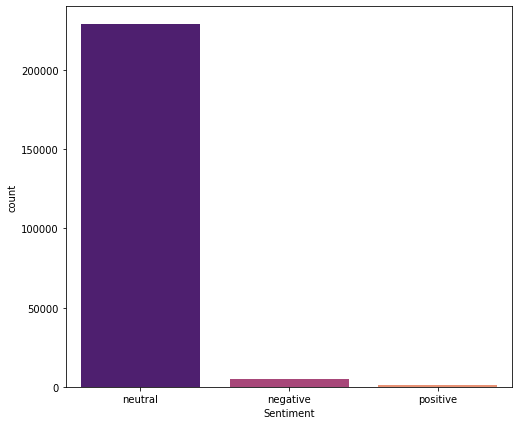

In [ ]:
plt.figure(figsize = (8,7))
sns.countplot(x="Sentiment", data=labeled_df, palette='magma')

In [ ]:
tweet_neg = labeled_df.loc[labeled_df['Sentiment'] == 'negative'].reset_index(drop=True)
tweet_net = labeled_df.loc[labeled_df['Sentiment'] == 'neutral'].reset_index(drop=True)
tweet_pos = labeled_df.loc[labeled_df['Sentiment'] == 'positive'].reset_index(drop=True)

In [ ]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(tweet_neg['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()